In [10]:
import pickle

import torch
from torchvision.transforms import v2 as transforms

import numpy as np
from ultralytics import YOLO

from keyrover import *
from keyrover.datasets import *
from keyrover.vision import *
from keyrover.color import image_color
from keyrover.ml import get_device
from keyrover.homography import *

In [3]:
device = get_device()

In [9]:
SIZE = (256, 256)

mean = torch.tensor([[121.73, 304.18, 521.91, 321.19, 518.25, 182.49, 135.07, 166.05]], device=device)
std = torch.tensor([[295.45, 322.01, 291.26, 333.85, 291.21, 329.92, 298.24, 317.73]], device=device)

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(*get_dataset_norm_params(version=3))
])

with open(f"{RAW_TEXCOORDS}/key_texcoords_palette.bin", "rb") as file:
    palette = pickle.load(file)

In [6]:
from torchvision import models
import lightning as pl


class CornersRegressionModel(pl.LightningModule):
    def __init__(self, lr: float | None = None) -> None:
        super().__init__()

        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        self.model.fc = torch.nn.Sequential(
            torch.nn.Linear(self.model.fc.in_features, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
        )

        self.loss_fn = torch.nn.MSELoss()

        self.learning_rate = lr
        self.lr = self.learning_rate
        self.save_hyperparameters()

    def predict(self, image: torch.Tensor, mask: bool = True) -> np.ndarray:
        image = image.to(self.device)
        if len(image.shape) == 3:
            image = image.unsqueeze(0)

        with torch.no_grad():
            pred = self.forward(image, mask=mask).cpu().numpy()

        if len(pred) == 1:
            return pred[0,]
        return pred

    def forward(self, image: torch.Tensor, mask: bool = True) -> torch.Tensor:
        return self.model(image)

    def _step(self, batch: tuple[torch.Tensor, torch.Tensor], stage: str) -> float:
        image, target = batch
        predictions = self(image)

        loss = self.loss_fn(predictions, target)
        self.log(f"{stage}_loss", loss)
        return loss

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "train")

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "val")

    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> float:
        return self._step(batch, "test")

    def configure_optimizers(self) -> dict:
        optimizer = torch.optim.AdamW(self.parameters(), lr=(self.lr or self.learning_rate))
        return {"optimizer": optimizer}

In [14]:
model = CornersRegressionModel()
model.load_state_dict(torch.load(f"models/corner-prediction/magic-wave-28.pt", weights_only=True))
model.to(device)
model.eval()

yolo = YOLO("models/yolo/train4/weights/best.pt")


0: 320x320 47 keys, 20.5ms
Speed: 1.1ms preprocess, 20.5ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)


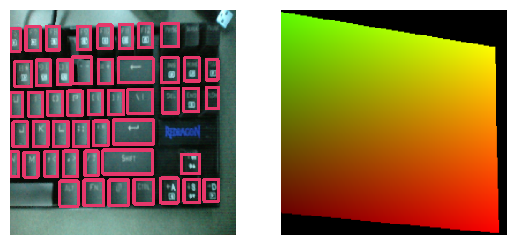

In [63]:
img = cv2.imread(f"{TEST_DATASET}/2-new.jpg")
img = cv2.resize(img, SIZE)

pred = yolo.predict(img, conf=0.3, iou=0.3)[0]

img = transform(img)
img = img.unsqueeze(0).to(device)

mask = model(img) * std + mean
mask = tuple(*mask.reshape((1, 4, 2, 1)))
mask = corners_to_texture_coordinates(mask)[0]
mask = reorder_image_axes(mask)

mask = cv2.resize(mask, SIZE)

out = plot_yolo(pred, scale=3, draw_text=False, plot=False)
imshow(out, mask)

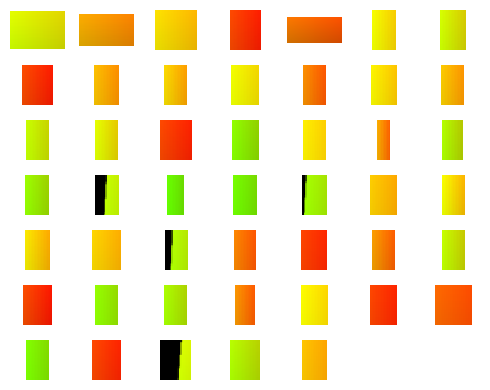

In [64]:
img = pred.orig_img

keys = [crop_rect(mask, box) for box in pred.boxes]
colors = np.array([color[:2] for key in keys if (color := image_color(key, reduce="mean")) is not None])
show_images(keys, figsize=(5, 4))

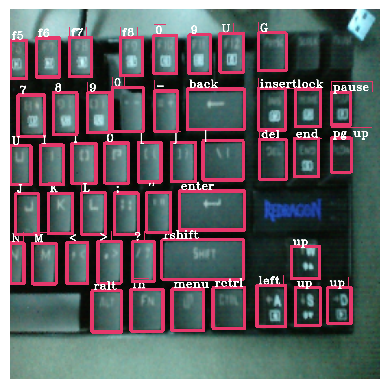

In [65]:
# Unfiltered classification algorithmt

classes = [palette[tuple(color)] for color in to_palette(colors, palette.colors)]
labels = [id_to_key.get(cls) for cls in classes]

plot_predictions(pred.orig_img, pred.boxes, labels, font_size=0.25, line_width=0, scale=5)

In [49]:
# Greedy classification algorithm

n = colors.shape[0]
m = palette.colors.shape[0]

color_matrix = np.repeat(colors[:, np.newaxis], m, axis=1)
dist = np.linalg.norm(color_matrix - palette.colors, axis=-1)
labels = [None] * n

for _ in range(n):
    index = np.unravel_index(dist.argmin(), dist.shape)
    closest_color = palette[index[1]]
    closest_key = palette[tuple(closest_color)]

    labels[index[0]] = id_to_key.get(closest_key)
    dist[index[0]] = float("inf")
    dist[:, index[1]] = float("inf")

plot_predictions(pred.orig_img, pred.boxes, labels, font_size=0.25, line_width=0, scale=5)

KeyError: 8

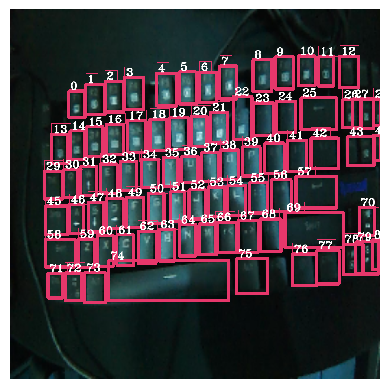

In [60]:
class Box:
    def __init__(self, box, n: int, color):            
        try:
            self.x, self.y, self.w, self.h = map(float, box.xywh[0])
        except AttributeError:
            self.x, self.y = box
            self.w = 0
            self.h = 0
            
        self.n = n

        self.box = box
        self.color = color

    def __sub__(self, other):
        # return (self.color - other.color)[:2]
        return np.array([self.x - other.x, self.y - other.y])

    def __repr__(self):
        return f"Box({self.x:.2f}, {self.y:.2f}, n={self.n})"

    def norm(self) -> float:
        return (self.x ** 2 + self.y ** 2) ** 0.5

    def topleft(self):
        return np.array([self.x - self.w / 2, self.y - self.h / 2])

    def topright(self):
        return np.array([self.x + self.w / 2, self.y - self.h / 2])

    def bottomleft(self):
        return np.array([self.x - self.w / 2, self.y + self.h / 2])

    def bottomright(self):
        return np.array([self.x + self.w / 2, self.y + self.h / 2])

    @property
    def xyxy(self) -> np.ndarray:
        return np.array([[self.x - self.w / 2, self.y - self.h / 2, self.x + self.w / 2, self.y + self.h / 2]])

    area = property(lambda self: self.w * self.h)


def sort_boxes(boxes):
    sorted_boxes = []
    rows = []

    while len(boxes):
        a = sorted(boxes, key=lambda p: p.x + 2 * p.y)[0]  # top-left box
        b = sorted(boxes, key=lambda p: p.x - 2 * p.y)[-1]  # top-right box

        if a == b:
            boxes.remove(a)
            continue

        # u1 = b.topright() - a.topleft()
        # u1 /= np.linalg.norm(u1)
        # 
        # u2 = b.bottomright() - a.bottomleft()
        # u2 /= np.linalg.norm(u2)

        u3 = b - a  # normalized direction vector
        u3 /= np.linalg.norm(u3)

        row = []
        remaining = []

        for box in boxes:
            # d1 = abs(np.cross(box - a.topleft(), u1))  # distance between box and lines
            # d2 = abs(np.cross(box - a.bottomleft(), u2))  # distance between box and lines
            d3 = abs(np.cross(box - a, u3))

            (row if (d3 < 15) else remaining).append(box)  # todo better threshold

        if len(row) <= 2:
            boxes.remove(a)
            boxes.remove(b)
            continue

        row = sorted(row, key=lambda h: h.x)
        rows.append(row)
        sorted_boxes.extend(row)
        boxes = remaining

    return sorted_boxes, rows


boxes, rows = sort_boxes([Box(box, i, color) for i, (box, color) in enumerate(zip(pred.boxes, colors))])
plot_predictions(pred.orig_img, boxes, range(len(boxes)), font_size=0.25, line_width=0, scale=5)

In [61]:
_, sorted_palette = sort_boxes([Box((color[0], -color[1]), i, color) for i, color in enumerate(palette.colors)])

print(len(sorted_palette))

sorted_palette_indices = [[palette[tuple(box.color[:2])] for box in row] for row in sorted_palette]
sorted_palette = [[box.color for box in row] for row in sorted_palette]
len(sorted_palette)

1


1

In [62]:
n_hat = len(boxes)

offsets = [1, 1, 0, 0, 0, 1]

layout = []
palette_indices = []
for i, row in enumerate(rows):
    offset = offsets[i]
    layout.extend(sorted_palette[i][offset:len(row) + offset])
    palette_indices.append(sorted_palette_indices[i][offset:len(row) + offset])

layout = np.array(layout)
min_ = layout.min(axis=0)
max_ = layout.max(axis=0)
print(min_, max_)
layout = (layout - min_) / (max_ - min_) - 0.5

L = layout.flatten(order="F")

I = np.ones((layout.shape[0], 1))
layout = np.asarray(np.bmat([layout, I]))
layout

IndexError: list index out of range

In [45]:
C = np.array([box.color for box in boxes])
C = C - C.min(axis=0)
C /= C.max(axis=0)
C -= 0.5

Z = np.zeros((C.shape[0], 1))
I = np.ones((C.shape[0], 1))
P = np.asarray(np.bmat([[C, Z, Z, I, Z], [Z, Z, C, I, Z]]))
# P = np.asarray(np.bmat([[C, Z], [Z, C]]))

C = np.asarray(np.bmat([C, I]))
P

array([[   -0.42882,     0.48388,           0,           0,           1,           0],
       [   -0.35915,     0.49507,           0,           0,           1,           0],
       [   -0.29002,     0.49295,           0,           0,           1,           0],
       [   -0.19705,     0.47397,           0,           0,           1,           0],
       [  -0.074003,     0.49494,           0,           0,           1,           0],
       [ -0.0059625,     0.48022,           0,           0,           1,           0],
       [   0.064007,     0.47383,           0,           0,           1,           0],
       [    0.17284,     0.48544,           0,           0,           1,           0],
       [    0.28892,         0.5,           0,           0,           1,           0],
       [    0.34064,      0.4923,           0,           0,           1,           0],
       [    0.40117,     0.48551,           0,           0,           1,           0],
       [   -0.48687,     0.21297,          

In [47]:
Pplus = np.linalg.pinv(P)
Pplus

array([[  -0.067528,    -0.05619,    -0.04493,   -0.029778,  -0.0097544,   0.0013367,    0.012736,    0.030451,    0.049343,    0.057771,    0.067635,   -0.076785,   -0.067189,    -0.05437,   -0.042368,   -0.028531,   -0.016816,  -0.0045427,   0.0083276,    0.022397,    0.034445,    0.046732,    0.057366,
           0.068035,   -0.078793,   -0.072559,   -0.061015,   -0.048328,   -0.036157,   -0.023639,   -0.010114,  0.00061629,     0.01626,    0.027996,    0.040766,    0.054899,    0.065122,    0.075686,   -0.074142,   -0.067526,    -0.05839,   -0.046414,   -0.031631,   -0.022866,   -0.013142,   0.0032541,
           0.015594,    0.028906,     0.04286,    0.059117,    0.075355,   -0.072986,    -0.06111,   -0.047255,   -0.036427,   -0.027764,   -0.019358,  -0.0067783,   0.0066041,     0.02095,    0.034422,    0.047657,    0.074302,   -0.074264,   -0.055743,   -0.018058,    0.033146,     0.04671,    0.069495,
            0.08443,   0.0018948,   0.0019544,   0.0020229,   0.0021266,    0.0

In [63]:
# Pplus = np.linalg.pinv(P)

# I = np.identity(6)
# y = np.array([0, 0, 0, 0, 0, 0])

(a, b, c, d, tx, ty), _, _, _ = np.linalg.lstsq(P, L)
# a, b, c, d, tx, ty = (I - Pplus @ P) @ y + Pplus @ L
A = np.array([[a, b, tx], [c, d, ty], [0, 0, 1]])

# a, b, c, d = np.linalg.inv(P.T @ P) @ P.T @ L
# A = np.array([[a, b], [c, d]])

C_hat = (A @ C.T).T

print("Before:", np.linalg.norm(layout.flatten() - C.flatten()))
print("After:", np.linalg.norm(layout.flatten() - C_hat.flatten()))

x, y = ((palette - min_) / (max_ - min_) - 0.5).T
plt.scatter(x, y, marker=".", c="red")

x, y, _ = layout.T
plt.scatter(x, y, marker=".", c="green")

for i in range(len(x)):
    plt.annotate(i, (x[i], y[i]))

x, y, _ = C_hat.T
plt.scatter(x, y, marker=".")

x, y, _ = C.T
plt.scatter(x, y, marker=".", c="#ccc")

A

NameError: name 'P' is not defined

In [673]:
x, y = layout.T
plt.scatter(x, y, marker=".", c="green")

for i in range(len(x)):
    plt.annotate(i, (x[i], y[i]))

x, y = C_hat.T
plt.scatter(x, y, marker=".")

x, y = C.T
plt.scatter(x, y, marker=".", c="#ccc")

ValueError: too many values to unpack (expected 2)

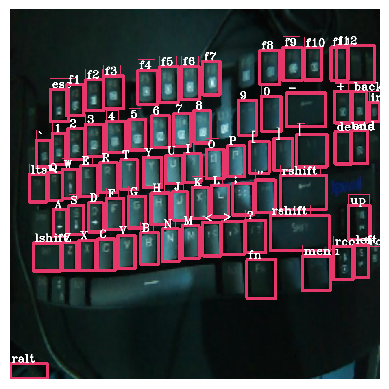

In [771]:
# Topological + Greedy classification algorithm

labels = [id_to_key.get(label, "rshift") for row in palette_indices for label in row]
plot_predictions(pred.orig_img, boxes, labels, font_size=0.25, line_width=0, scale=5)